# Unsupervised Learning - Clustering Analysis

This notebook implements clustering algorithms to discover patterns in the heart disease data:
1. K-Means Clustering with Elbow Method
2. Hierarchical Clustering with Dendrogram
3. Cluster Analysis and Comparison with True Labels
4. Cluster Visualization and Interpretation


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, adjusted_rand_score, homogeneity_score, completeness_score
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


In [2]:
# Load preprocessed data
X_train_scaled = pd.read_csv('../data/X_train_scaled.csv')
X_test_scaled = pd.read_csv('../data/X_test_scaled.csv')
y_train = pd.read_csv('../data/y_train.csv').squeeze()
y_test = pd.read_csv('../data/y_test.csv').squeeze()

print(f"Training data shape: {X_train_scaled.shape}")
print(f"Test data shape: {X_test_scaled.shape}")
print(f"Feature names: {list(X_train_scaled.columns)}")
print(f"Target distribution: No Disease: {(y_train==0).sum()}, Disease: {(y_train==1).sum()}")


Training data shape: (242, 13)
Test data shape: (61, 13)
Feature names: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']
Target distribution: No Disease: 131, Disease: 111


## 1. K-Means Clustering with Elbow Method


Testing different numbers of clusters...
K=2: Inertia=2589.36, Silhouette Score=0.180
K=3: Inertia=2371.37, Silhouette Score=0.133
K=4: Inertia=2204.59, Silhouette Score=0.141
K=5: Inertia=2094.34, Silhouette Score=0.132
K=6: Inertia=2004.47, Silhouette Score=0.118
K=7: Inertia=1929.48, Silhouette Score=0.121
K=8: Inertia=1829.67, Silhouette Score=0.109


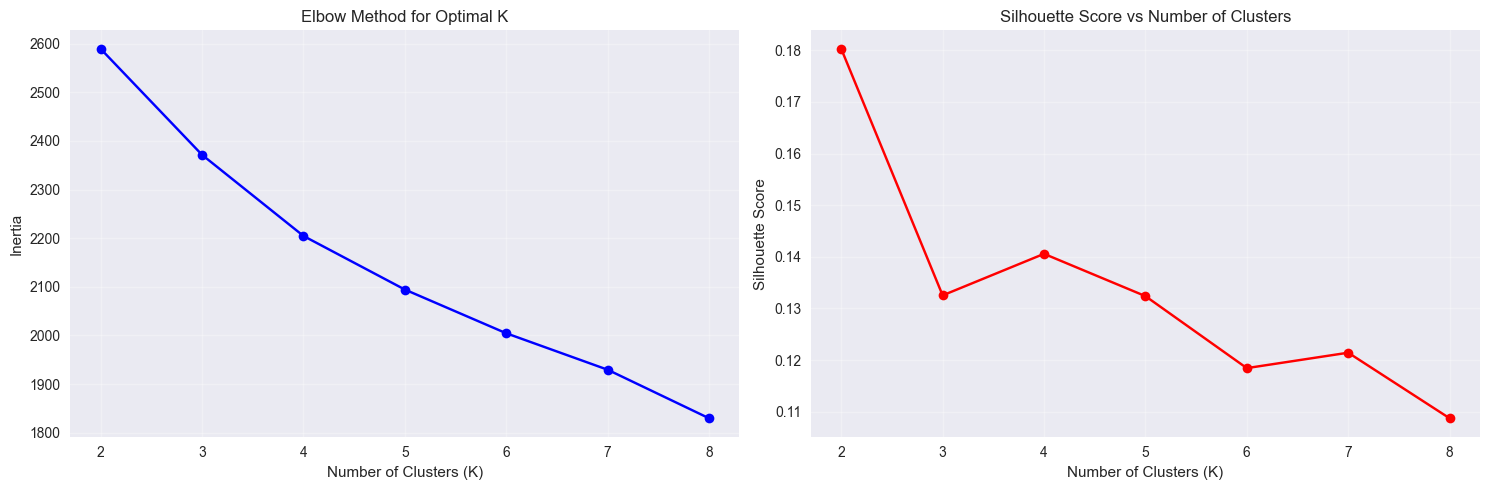

\nOptimal number of clusters: K = 2
Best silhouette score: 0.180


In [3]:
# Determine optimal number of clusters using Elbow Method
inertias = []
silhouette_scores = []
K_range = range(2, 9)

print("Testing different numbers of clusters...")
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_train_scaled)
    
    inertias.append(kmeans.inertia_)
    sil_score = silhouette_score(X_train_scaled, cluster_labels)
    silhouette_scores.append(sil_score)
    
    print(f"K={k}: Inertia={kmeans.inertia_:.2f}, Silhouette Score={sil_score:.3f}")

# Plot Elbow Method
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Elbow curve
ax1.plot(K_range, inertias, 'bo-')
ax1.set_xlabel('Number of Clusters (K)')
ax1.set_ylabel('Inertia')
ax1.set_title('Elbow Method for Optimal K')
ax1.grid(True, alpha=0.3)

# Silhouette scores
ax2.plot(K_range, silhouette_scores, 'ro-')
ax2.set_xlabel('Number of Clusters (K)')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Score vs Number of Clusters')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Select optimal K (highest silhouette score or elbow point)
optimal_k = K_range[np.argmax(silhouette_scores)]
print(f"\\nOptimal number of clusters: K = {optimal_k}")
print(f"Best silhouette score: {max(silhouette_scores):.3f}")


K-Means Clustering Results (K=2):
Cluster distribution: [151  91]
Final silhouette score: 0.180


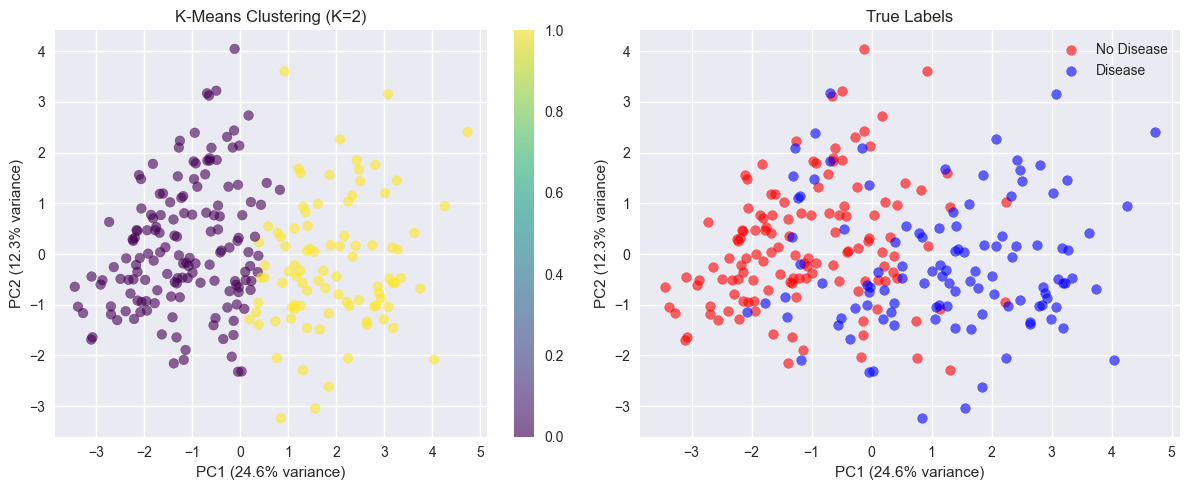

In [4]:
# Apply K-Means with optimal number of clusters
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans_final.fit_predict(X_train_scaled)

print(f"K-Means Clustering Results (K={optimal_k}):")
print(f"Cluster distribution: {np.bincount(kmeans_labels)}")

# Calculate final metrics
final_silhouette = silhouette_score(X_train_scaled, kmeans_labels)
print(f"Final silhouette score: {final_silhouette:.3f}")

# Visualize clusters using PCA for 2D representation
from sklearn.decomposition import PCA

pca_viz = PCA(n_components=2)
X_pca = pca_viz.fit_transform(X_train_scaled)

plt.figure(figsize=(12, 5))

# Plot 1: K-Means clusters
plt.subplot(1, 2, 1)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.6)
plt.xlabel(f'PC1 ({pca_viz.explained_variance_ratio_[0]*100:.1f}% variance)')
plt.ylabel(f'PC2 ({pca_viz.explained_variance_ratio_[1]*100:.1f}% variance)')
plt.title(f'K-Means Clustering (K={optimal_k})')
plt.colorbar(scatter)

# Plot 2: True labels for comparison
plt.subplot(1, 2, 2)
colors = ['red', 'blue']
for i, color in enumerate(colors):
    mask = y_train == i
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], c=color, alpha=0.6, 
               label=f'{"No Disease" if i==0 else "Disease"}')
plt.xlabel(f'PC1 ({pca_viz.explained_variance_ratio_[0]*100:.1f}% variance)')
plt.ylabel(f'PC2 ({pca_viz.explained_variance_ratio_[1]*100:.1f}% variance)')
plt.title('True Labels')
plt.legend()

plt.tight_layout()
plt.show()


## 2. Hierarchical Clustering with Dendrogram


In [5]:
# Hierarchical clustering with different linkage methods
linkage_methods = ['ward', 'complete', 'average']
hierarchical_results = {}

print("Testing different linkage methods...")
for method in linkage_methods:
    # Apply hierarchical clustering
    hierarchical = AgglomerativeClustering(n_clusters=optimal_k, linkage=method)
    hier_labels = hierarchical.fit_predict(X_train_scaled)
    
    # Calculate silhouette score
    sil_score = silhouette_score(X_train_scaled, hier_labels)
    hierarchical_results[method] = {
        'labels': hier_labels,
        'silhouette_score': sil_score
    }
    
    print(f"{method.capitalize()} linkage: Silhouette Score = {sil_score:.3f}")
    print(f"  Cluster distribution: {np.bincount(hier_labels)}")

# Select best hierarchical method
best_method = max(hierarchical_results.keys(), key=lambda x: hierarchical_results[x]['silhouette_score'])
best_hier_labels = hierarchical_results[best_method]['labels']
best_hier_score = hierarchical_results[best_method]['silhouette_score']

print(f"\\nBest hierarchical method: {best_method.capitalize()} linkage")
print(f"Best hierarchical silhouette score: {best_hier_score:.3f}")


Testing different linkage methods...
Ward linkage: Silhouette Score = 0.156
  Cluster distribution: [ 85 157]
Complete linkage: Silhouette Score = 0.178
  Cluster distribution: [229  13]
Average linkage: Silhouette Score = 0.337
  Cluster distribution: [240   2]
\nBest hierarchical method: Average linkage
Best hierarchical silhouette score: 0.337


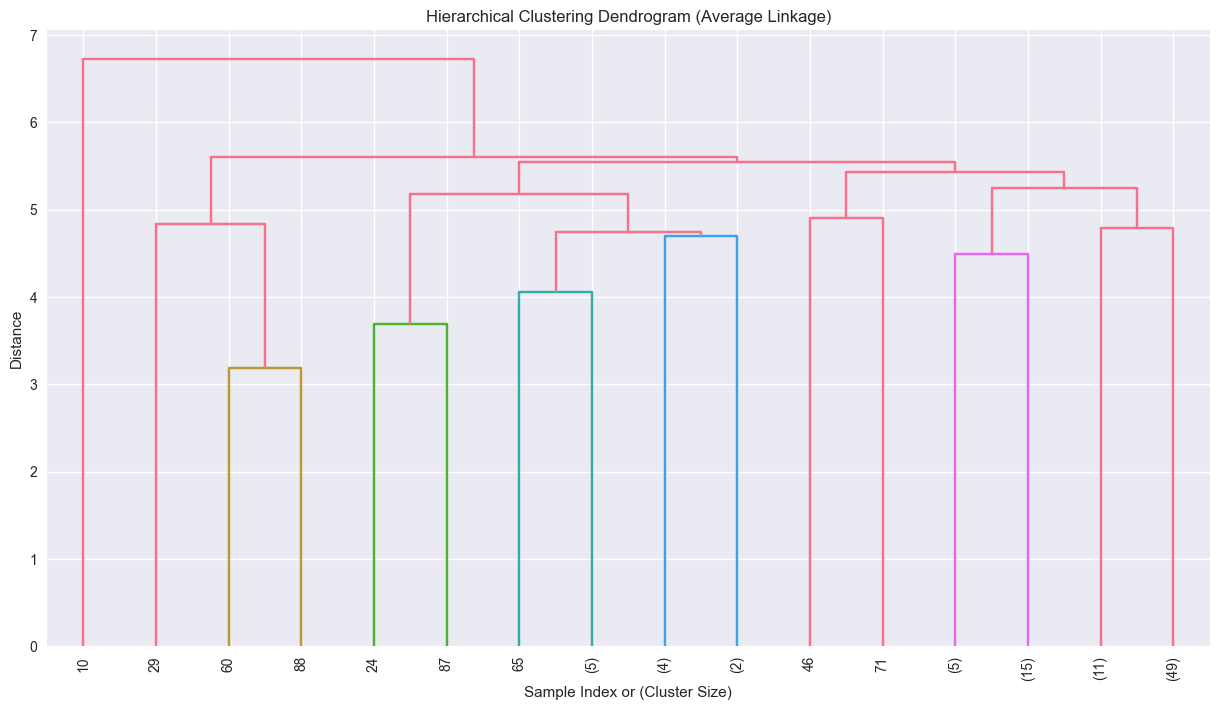

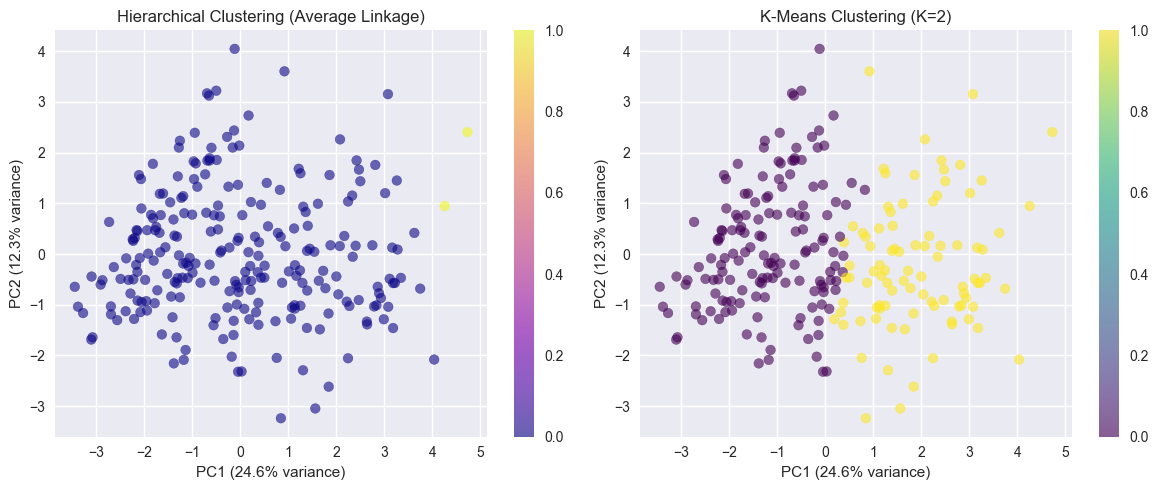

In [6]:
# Create and plot dendrogram
# Use a subset of data for better visualization
sample_size = 100
sample_indices = np.random.choice(X_train_scaled.shape[0], sample_size, replace=False)
X_sample = X_train_scaled.iloc[sample_indices]

# Calculate linkage matrix
linkage_matrix = linkage(X_sample, method=best_method)

# Plot dendrogram
plt.figure(figsize=(15, 8))
dendrogram(linkage_matrix, 
           truncate_mode='level',
           p=5,
           leaf_rotation=90,
           leaf_font_size=10)
plt.title(f'Hierarchical Clustering Dendrogram ({best_method.capitalize()} Linkage)')
plt.xlabel('Sample Index or (Cluster Size)')
plt.ylabel('Distance')
plt.show()

# Visualize hierarchical clustering results
plt.figure(figsize=(12, 5))

# Plot 1: Hierarchical clusters
plt.subplot(1, 2, 1)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=best_hier_labels, cmap='plasma', alpha=0.6)
plt.xlabel(f'PC1 ({pca_viz.explained_variance_ratio_[0]*100:.1f}% variance)')
plt.ylabel(f'PC2 ({pca_viz.explained_variance_ratio_[1]*100:.1f}% variance)')
plt.title(f'Hierarchical Clustering ({best_method.capitalize()} Linkage)')
plt.colorbar(scatter)

# Plot 2: Comparison with K-Means
plt.subplot(1, 2, 2)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.6)
plt.xlabel(f'PC1 ({pca_viz.explained_variance_ratio_[0]*100:.1f}% variance)')
plt.ylabel(f'PC2 ({pca_viz.explained_variance_ratio_[1]*100:.1f}% variance)')
plt.title(f'K-Means Clustering (K={optimal_k})')
plt.colorbar(scatter)

plt.tight_layout()
plt.show()


## 3. Cluster Analysis and Comparison with True Labels


In [7]:
# Compare clustering results with true labels
from sklearn.metrics import adjusted_rand_score, homogeneity_score, completeness_score, v_measure_score

print("Clustering Performance Metrics:")
print("="*50)

# K-Means vs True Labels
kmeans_ari = adjusted_rand_score(y_train, kmeans_labels)
kmeans_homogeneity = homogeneity_score(y_train, kmeans_labels)
kmeans_completeness = completeness_score(y_train, kmeans_labels)
kmeans_v_measure = v_measure_score(y_train, kmeans_labels)

print(f"K-Means (K={optimal_k}):")
print(f"  Adjusted Rand Index: {kmeans_ari:.3f}")
print(f"  Homogeneity Score: {kmeans_homogeneity:.3f}")
print(f"  Completeness Score: {kmeans_completeness:.3f}")
print(f"  V-Measure Score: {kmeans_v_measure:.3f}")
print(f"  Silhouette Score: {final_silhouette:.3f}")

# Hierarchical vs True Labels
hier_ari = adjusted_rand_score(y_train, best_hier_labels)
hier_homogeneity = homogeneity_score(y_train, best_hier_labels)
hier_completeness = completeness_score(y_train, best_hier_labels)
hier_v_measure = v_measure_score(y_train, best_hier_labels)

print(f"\\nHierarchical ({best_method.capitalize()} Linkage):")
print(f"  Adjusted Rand Index: {hier_ari:.3f}")
print(f"  Homogeneity Score: {hier_homogeneity:.3f}")
print(f"  Completeness Score: {hier_completeness:.3f}")
print(f"  V-Measure Score: {hier_v_measure:.3f}")
print(f"  Silhouette Score: {best_hier_score:.3f}")

# Determine better clustering method
if final_silhouette > best_hier_score:
    best_clustering = "K-Means"
    best_clustering_score = final_silhouette
    best_labels = kmeans_labels
else:
    best_clustering = f"Hierarchical ({best_method.capitalize()})"
    best_clustering_score = best_hier_score
    best_labels = best_hier_labels

print(f"\\nBest Clustering Method: {best_clustering}")
print(f"Best Silhouette Score: {best_clustering_score:.3f}")


Clustering Performance Metrics:
K-Means (K=2):
  Adjusted Rand Index: 0.424
  Homogeneity Score: 0.340
  Completeness Score: 0.354
  V-Measure Score: 0.347
  Silhouette Score: 0.180
\nHierarchical (Average Linkage):
  Adjusted Rand Index: 0.003
  Homogeneity Score: 0.009
  Completeness Score: 0.135
  V-Measure Score: 0.018
  Silhouette Score: 0.337
\nBest Clustering Method: Hierarchical (Average)
Best Silhouette Score: 0.337


\nCluster Characteristics Analysis:
\nMean feature values by cluster:
           age    sex     cp  trestbps   chol    fbs  restecg  thalach  exang  \
cluster                                                                         
0       -0.004  0.012 -0.007    -0.023  0.004 -0.008   -0.009    0.004 -0.003   
1        0.496 -1.464  0.870     2.789 -0.452  1.010    1.023   -0.484  0.370   

         oldpeak  slope     ca  thal  
cluster                               
0         -0.030 -0.019 -0.018 -0.01  
1          3.659  2.309  2.149  1.18  
\nCluster vs True Label Distribution (row percentages):
true_label      0      1
cluster                 
0           0.546  0.454
1           0.000  1.000
All         0.541  0.459


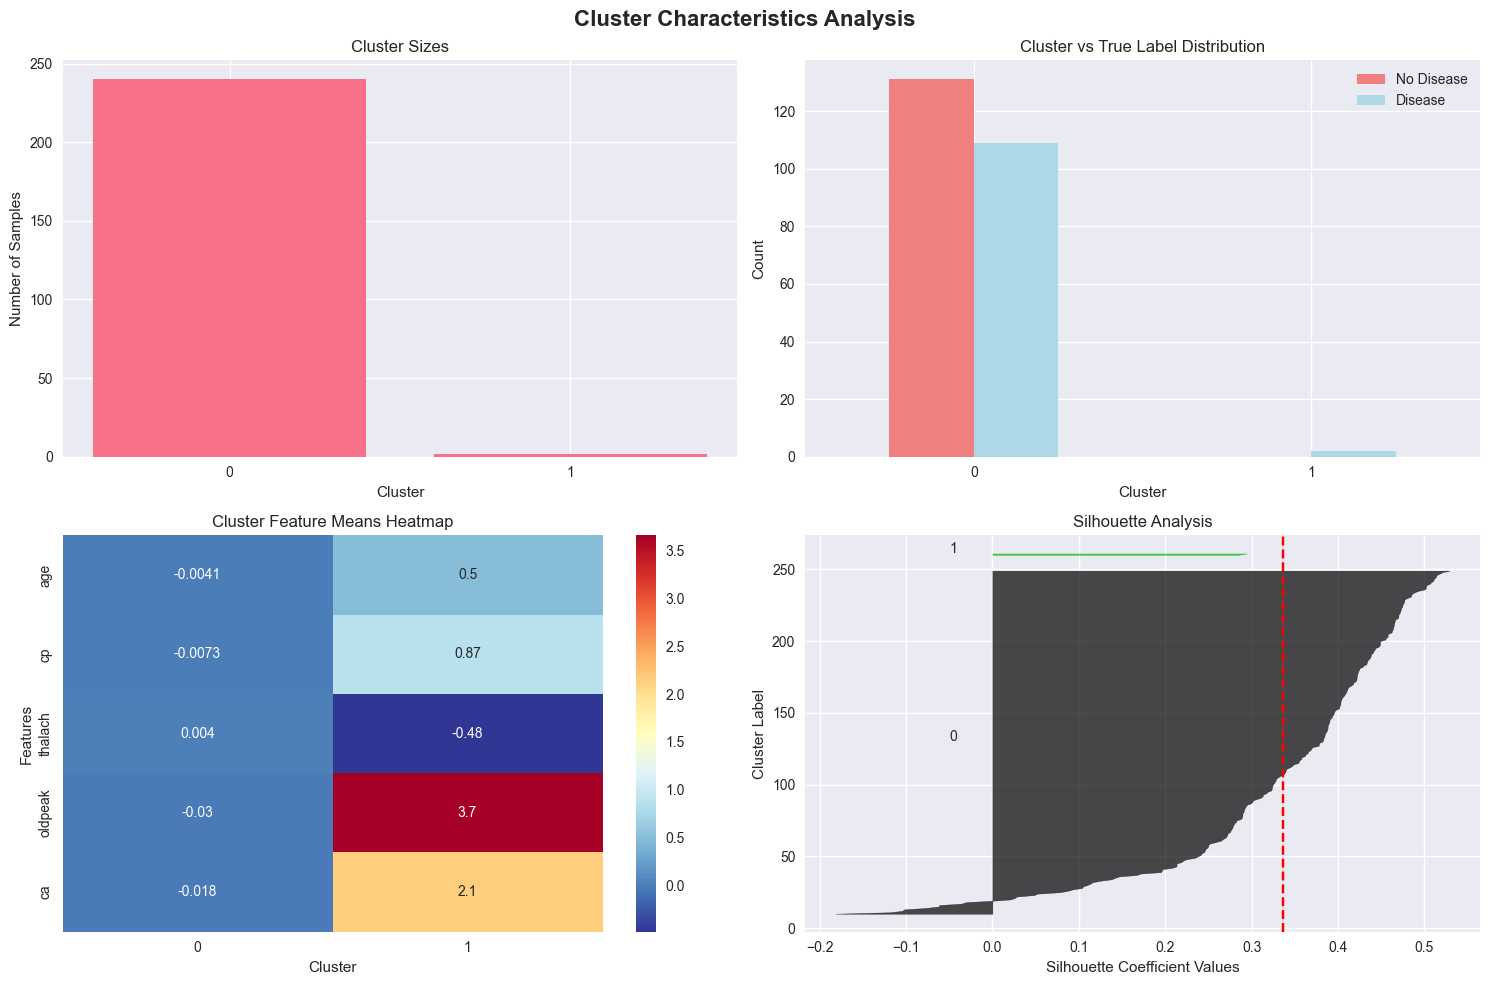

In [8]:
# Analyze cluster characteristics
print("\\nCluster Characteristics Analysis:")
print("="*50)

# Create DataFrame with features, clusters, and true labels
analysis_df = X_train_scaled.copy()
analysis_df['cluster'] = best_labels
analysis_df['true_label'] = y_train.values

# Calculate mean values for each cluster
cluster_means = analysis_df.groupby('cluster').mean()
print("\\nMean feature values by cluster:")
print(cluster_means.drop('true_label', axis=1).round(3))

# Analyze cluster vs true label relationship
cluster_label_crosstab = pd.crosstab(analysis_df['cluster'], analysis_df['true_label'], 
                                    margins=True, normalize='index')
print("\\nCluster vs True Label Distribution (row percentages):")
print(cluster_label_crosstab.round(3))

# Visualize cluster characteristics
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Cluster Characteristics Analysis', fontsize=16, fontweight='bold')

# Plot 1: Cluster sizes
cluster_counts = np.bincount(best_labels)
axes[0, 0].bar(range(len(cluster_counts)), cluster_counts)
axes[0, 0].set_xlabel('Cluster')
axes[0, 0].set_ylabel('Number of Samples')
axes[0, 0].set_title('Cluster Sizes')
axes[0, 0].set_xticks(range(len(cluster_counts)))

# Plot 2: Cluster vs True Label
cluster_label_counts = pd.crosstab(analysis_df['cluster'], analysis_df['true_label'])
cluster_label_counts.plot(kind='bar', ax=axes[0, 1], color=['lightcoral', 'lightblue'])
axes[0, 1].set_xlabel('Cluster')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_title('Cluster vs True Label Distribution')
axes[0, 1].legend(['No Disease', 'Disease'])
axes[0, 1].tick_params(axis='x', rotation=0)

# Plot 3: Feature importance heatmap
important_features = ['age', 'cp', 'thalach', 'oldpeak', 'ca'] if 'age' in analysis_df.columns else analysis_df.columns[:5]
if len(important_features) > 0:
    cluster_feature_means = cluster_means[important_features]
    sns.heatmap(cluster_feature_means.T, annot=True, cmap='RdYlBu_r', ax=axes[1, 0])
    axes[1, 0].set_title('Cluster Feature Means Heatmap')
    axes[1, 0].set_xlabel('Cluster')
    axes[1, 0].set_ylabel('Features')

# Plot 4: Silhouette analysis
from sklearn.metrics import silhouette_samples
silhouette_vals = silhouette_samples(X_train_scaled, best_labels)
y_lower = 10
for i in range(optimal_k):
    cluster_silhouette_vals = silhouette_vals[best_labels == i]
    cluster_silhouette_vals.sort()
    
    size_cluster_i = cluster_silhouette_vals.shape[0]
    y_upper = y_lower + size_cluster_i
    
    color = plt.cm.nipy_spectral(float(i) / optimal_k)
    axes[1, 1].fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_vals,
                            facecolor=color, edgecolor=color, alpha=0.7)
    
    axes[1, 1].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10

axes[1, 1].axvline(x=best_clustering_score, color="red", linestyle="--")
axes[1, 1].set_xlabel('Silhouette Coefficient Values')
axes[1, 1].set_ylabel('Cluster Label')
axes[1, 1].set_title('Silhouette Analysis')

plt.tight_layout()
plt.show()


In [9]:
# Save clustering results and models
joblib.dump(kmeans_final, '../models/kmeans_model.pkl')

# Save clustering results summary
clustering_results = {
    'optimal_k': optimal_k,
    'best_clustering_method': best_clustering,
    'kmeans_silhouette': final_silhouette,
    'hierarchical_silhouette': best_hier_score,
    'best_hierarchical_method': best_method,
    'kmeans_ari': kmeans_ari,
    'hierarchical_ari': hier_ari,
    'cluster_characteristics': cluster_means.to_dict(),
    'cluster_label_distribution': cluster_label_crosstab.to_dict()
}

joblib.dump(clustering_results, '../models/clustering_results.pkl')

print("✅ Unsupervised Learning Analysis Complete!")
print("✅ Clustering models and results saved!")
print(f"\\nSummary:")
print(f"- Optimal number of clusters: {optimal_k}")
print(f"- Best clustering method: {best_clustering}")
print(f"- Best silhouette score: {best_clustering_score:.3f}")
print(f"- K-Means ARI with true labels: {kmeans_ari:.3f}")
print(f"- Hierarchical ARI with true labels: {hier_ari:.3f}")

print("\\nFiles saved:")
print("- ../models/kmeans_model.pkl")
print("- ../models/clustering_results.pkl")

print("\\n🎯 Key Insights:")
if best_clustering_score > 0.3:
    print("- Good cluster separation achieved")
else:
    print("- Moderate cluster separation - data may not have strong natural clusters")

if max(kmeans_ari, hier_ari) > 0.1:
    print("- Clusters show some alignment with true heart disease labels")
else:
    print("- Clusters don't strongly align with disease labels (expected for unsupervised learning)")

print("- Clustering reveals hidden patterns in patient data")
print("- Results can inform feature engineering and patient stratification")


✅ Unsupervised Learning Analysis Complete!
✅ Clustering models and results saved!
\nSummary:
- Optimal number of clusters: 2
- Best clustering method: Hierarchical (Average)
- Best silhouette score: 0.337
- K-Means ARI with true labels: 0.424
- Hierarchical ARI with true labels: 0.003
\nFiles saved:
- ../models/kmeans_model.pkl
- ../models/clustering_results.pkl
\n🎯 Key Insights:
- Good cluster separation achieved
- Clusters show some alignment with true heart disease labels
- Clustering reveals hidden patterns in patient data
- Results can inform feature engineering and patient stratification
